In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import datetime
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import coint
import warnings
warnings.simplefilter('ignore')

This a investments  strategyment about pair trading: we want to find two stocks (one pair) such that their price movement should be similar:  
- For exmaple, if we think the stock prices of Facebook and Google are one pair, that is to said, if the price of Facebook goes up, then Google will also goes up
- Which is to say, the price difference of one pair should usually around 0, or technically, normalized with mean zero and a fixed standard deviation

The implement of this pair trading startegy would follow these steps:
- Upload data
- Data engeering: to define a pair, we need data from the stock market including price and volume, and the data from the stocks' financial statement such as  earnings
- Pairs formation: we will use the data in the previous step to compute pairs
- Investing and rebalancing: we will do this in a rolling base. For example, we will use data during 2006 - 2010 (five years) to decide pairs (we will invest in 100 pair for diversification), and then invest those pairs in 2011 (one year); and then use 2007 - 2011 to decide the trading in 2012

The traditional method for defining one pair is to compute the standard deviation of their price difference. In this notebook, beside the traditional method, we will also try one more novel method, which will be explained in the following part

# upload data

- rf: risk free rate will be used to compute excess return,
- stocks: stock market data includes stock ticks(PERMNO), price(PRC), volume(VOL), return(RET), and share outstanding(SHROUT); note that we those are monthly data, because daily price may contain more noise
- cstat: compustat annual data provides companies' annual financial statement

In [2]:
rf = pd.read_csv('risk-free_return.csv', parse_dates=[0], index_col=[0])
stocks = pd.read_hdf('crsp_monthly_stocks.h5', 'crsp')
cstat  = pd.read_hdf('compustat_annual.h5', 'cstat')

In [3]:
stocks.head()

,PERMNO,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT
0,10000.0,1986-01-31,10.0,3.0,3990.0,-4.375000,1771.0,NaN,3680.0
1,10000.0,1986-02-28,10.0,3.0,3990.0,-3.250000,828.0,-0.257143,3680.0
2,10000.0,1986-03-31,10.0,3.0,3990.0,-4.437500,1078.0,0.365385,3680.0
3,10000.0,1986-04-30,10.0,3.0,3990.0,-4.000000,957.0,-0.098592,3793.0
4,10000.0,1986-05-30,10.0,3.0,3990.0,-3.109375,1074.0,-0.222656,3793.0


In [4]:
cstat.head()

,DATADATE,FYEAR,LPERMNO,AT,CEQ,LT,PSTK,SEQ,IB,CAPX
0,1970-12-31,1970.0,25881.0,33.450,10.544,22.906,0.000,10.544,1.878,2.767
1,1971-12-31,1971.0,25881.0,29.330,8.381,20.948,0.000,8.382,0.138,1.771
2,1972-12-31,1972.0,25881.0,19.907,7.021,12.886,0.000,7.021,1.554,1.254
3,1973-12-31,1973.0,25881.0,21.771,8.567,13.204,0.000,8.567,1.863,1.633
4,1974-12-31,1974.0,25881.0,25.638,9.843,15.381,0.414,10.257,1.555,1.313


# Data engeering

### Stock market data:

Two particular issues about crsp_monthly_stocks: 
- we are using monthly price data, but some of the price date is not the last day of the month. In order to efficiently merger with accounting data later, we will force the date to be the last day of the month
- some price was added with a negative sign, this should be a error of the data, we take the absolute value for all price 

In [5]:
stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['PRC']  = np.abs(stocks['PRC'])

From the stock data, we will only use four features:
- industru code
- stock monthly price
- stock monthly return
- stock market volume: shares multiples price

In [6]:
stocks['MV'] = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHROUT','SHRCD','EXCHCD','VOL'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)
stocks.head()

SICCD       PRC       RET            MV
PERMNO  DATE                                                
10000.0 1986-01-31  3990.0  4.375000       NaN  16100.000000
        1986-02-28  3990.0  3.250000 -0.257143  11960.000000
        1986-03-31  3990.0  4.437500  0.365385  16330.000000
        1986-04-30  3990.0  4.000000 -0.098592  15172.000000
        1986-05-31  3990.0  3.109375 -0.222656  11793.859375

### Financial statement data: compustat

Compustat shows the company's financial situation at a particular time, but we cannot get access to those data that time. Investors have to wait until the company release its financial statement. 

As Fama French, we assume the company's financial statemnet will be available after half a year. e.g: financial statement at 2000-06-30 will be lease at 2000-12-31

Also, force the date to be the last day of the month

In [7]:
cstat['DATE'] = cstat['DATADATE'] + pd.DateOffset(months=6)
cstat['DATE'] = cstat['DATE'] + MonthEnd(0)

# LPERMNO in compustat means the stock tick, which ia the same as PERMNO in stock data
cstat.rename(index=str, columns={"LPERMNO":"PERMNO"}, inplace=True) 

cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)
cstat.head()

DATADATE   FYEAR      AT    CEQ      LT  PSTK    SEQ  \
PERMNO  DATE                                                                
10000.0 1987-04-30 1986-10-31  1986.0   2.115  0.418   1.697   0.0  0.418   
10001.0 1986-12-31 1986-06-30  1986.0  12.242  5.432   6.810   0.0  5.432   
        1987-12-31 1987-06-30  1987.0  11.771  5.369   6.402   0.0  5.369   
        1988-12-31 1988-06-30  1988.0  11.735  5.512   6.223   0.0  5.512   
        1989-12-31 1989-06-30  1989.0  18.565  6.321  12.244   0.0  6.321   

                       IB   CAPX  
PERMNO  DATE                      
10000.0 1987-04-30 -0.730  0.240  
10001.0 1986-12-31  0.669  0.551  
        1987-12-31  0.312  0.513  
        1988-12-31  0.542  0.240  
        1989-12-31  1.208  0.444

### Merger data of cstat into stock 

We use price(or return) information to define a pair. However, before that, we should consider the economic meanings of being a pair. 

In the Fama French three factors model, Fama thinks size factor and value/growth factor are the two specific factors (desides market factor) that can influence stocks' price. 

Thus, we will use market volume, P/E ratio, and industry code to define a stock category, and only consider pairs in the same category

we wil use earnings before extraordinary items (IB) in cstat to compute the P/E ratio

In [8]:
# one more issue before we merger the two data: there are duplicated obersations !
stocks = stocks.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
cstat  = cstat.sort_values(by = ['PERMNO','DATE','SEQ'], ascending = [True, True, False])
stocks = stocks[~stocks.index.duplicated(keep='first')]
cstat  = cstat[~cstat.index.duplicated(keep='first')]
stocks['XRET'] = stocks['RET'] - rf['RF']
stocks = stocks.drop("RET", axis = 1)
stocks['IB']   = cstat['IB']
stocks.head()

SICCD       PRC            MV      XRET  IB
PERMNO  DATE                                                    
10000.0 1986-01-31  3990.0  4.375000  16100.000000       NaN NaN
        1986-02-28  3990.0  3.250000  11960.000000 -0.262443 NaN
        1986-03-31  3990.0  4.437500  16330.000000  0.359385 NaN
        1986-04-30  3990.0  4.000000  15172.000000 -0.103792 NaN
        1986-05-31  3990.0  3.109375  11793.859375 -0.227556 NaN

### Now, we have finished the merger part. The data we will use the the following will be only the "stocks" data

We can see there are many NaN values in the IB column, because the financial data is yearly based and the stock price data is monthly based. Monthly IB is impossible, so we will pad the financial data back for the whole year

In [9]:
stocks['IBpad']  = stocks['IB'].groupby('PERMNO').fillna(method='pad', limit=15)

Then use the IBpad to compute the PE ratio.

Note that: we will use PE, MV and industry code(SICCD) to classify the stocks, so the previous's categories are based on previous information and we need to compute LAG_PE and LAG_MV, which are the previous month's data

In [10]:
stocks['PE'] = stocks['MV']/stocks['IBpad']/1000
stocks["LAG_PE"] = stocks.groupby("PERMNO")["PE"].shift(1)
stocks["LAG_MV"] = stocks.groupby("PERMNO")["MV"].shift(1)
stocks.drop(["IB", "IBpad", "PE", "MV"], axis=1, inplace=True)

### We want invest for 10 years (from 2008 to 2018), so we will only use data from the year of 2003
- e.g: use data from 2003 to 2007 to form trading pairs,and then invest for the following year of 2008

In [11]:
stocks = stocks.reset_index("PERMNO")
after2003_stocks = stocks.loc["2003":]
after2003_stocks.head()

,PERMNO,SICCD,PRC,XRET,LAG_PE,LAG_MV
DATE,,,,,,
2003-01-31,10001.0,4920.0,8.44,0.147143,13.594890,19046.440565
2003-02-28,10001.0,4920.0,8.74,0.034645,15.608879,21868.038913
2003-03-31,10001.0,4920.0,7.65,-0.110268,16.163697,22645.339407
2003-04-30,10001.0,4920.0,5.17,-0.325183,14.158780,19836.450247
2003-05-31,10001.0,4920.0,8.44,0.631595,9.568744,13405.810198


### A bird view for the data after2003_stocks

In [12]:
after2003_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795357 entries, 2003-01-31 to 2018-06-30
Data columns (total 6 columns):
PERMNO    795357 non-null float64
SICCD     795237 non-null float64
PRC       775263 non-null float64
XRET      771713 non-null float64
LAG_PE    736606 non-null float64
LAG_MV    776756 non-null float64
dtypes: float64(6)
memory usage: 42.5 MB


In [13]:
# dropping a few missing values
after2003_stocks.dropna(inplace=True)

In [14]:
number_of_stock = len(np.unique(after2003_stocks["PERMNO"])) 
print ("number of stocks: " + str(number_of_stock))
number_of_industry = len(np.unique(after2003_stocks["SICCD"])) 
print ("number of industry: " + str(number_of_industry))

number of stocks: 8152
number of industry: 1003


We have 8152 stocks and 1003 industries, but we do not need that detailed industry classification. We will we only use the first two characters to get a rough industry classification

In [15]:
# for the industry code, we only use the first two characters to get a rough industry classification
after2003_stocks["SICCD_2"] = after2003_stocks["SICCD"].apply(lambda x: str(x)[0:2])
after2003_stocks = after2003_stocks.drop("SICCD", axis = 1)
number_of_industry_2 = len(np.unique(after2003_stocks["SICCD_2"])) 
print ("number of rough industry: " + str(number_of_industry_2))

number of rough industry: 79


8152 stocks are devided into 79 categories, looks good!

# Let us summarize our dataset

In [16]:
after2003_stocks.head()

,PERMNO,PRC,XRET,LAG_PE,LAG_MV,SICCD_2
DATE,,,,,,
2003-01-31,10001.0,8.44,0.147143,13.594890,19046.440565,49
2003-02-28,10001.0,8.74,0.034645,15.608879,21868.038913,49
2003-03-31,10001.0,7.65,-0.110268,16.163697,22645.339407,49
2003-04-30,10001.0,5.17,-0.325183,14.158780,19836.450247,49
2003-05-31,10001.0,8.44,0.631595,9.568744,13405.810198,49


- PERMNO : the stock tick, we have 8152 stocks here
- PRC    : the stock price
- XRET   : monthly excess return
- LAG_PE : PE ratio of last month
- LAG_MV : MV ratio of last month
- SICCD_2: 79 industry code for 8152 stocks

# Useful functions

Devide data into five years training data and one year investing data, we will iterate for every six years' data

In [17]:
def divide_data(six_years_data):
    first_year = six_years_data.index.year.unique()[0]
    fifth_year = six_years_data.index.year.unique()[4]
    training_data = six_years_data.loc[str(first_year):str(fifth_year)]
    test_data = six_years_data.loc[str(fifth_year+1):]
    test_data.reset_index(inplace = True)
    training_data.reset_index(inplace = True)
    return training_data,test_data  #DATE  PERMNO PRC XRET LAG_PE LAG_MV SICCD_2

In [42]:
# test this function
training_data_test,test_data_test  = divide_data(after2003_stocks.loc["2003":"2008"])
training_data_test.head(1)

,DATE,PERMNO,PRC,XRET,LAG_PE,LAG_MV,SICCD_2
0,2003-01-31,10001.0,8.44,0.147143,13.59489,19046.440565,49


Some stocks' industry codes may change, so we will replace it by the latest SICCD
- Note that the input is training_data not the whole six years data, we will never know if the future industry code will change when we are at formation period

In [43]:
def clean_SICCD(training_data): #PERMNO PRC XRET LAG_MV LAG_PE SICCD_2; index :DATE
    latest_industry=pd.DataFrame(training_data.groupby(training_data["PERMNO"])["SICCD_2"].apply(lambda x:x.iloc[-1]))
    training_data.set_index("PERMNO",inplace=True )    
    training_data["SICCD_2"] = latest_industry["SICCD_2"]
    training_data.reset_index(inplace=True)
    return training_data #PERMNO DATE PRC XRET LAG_PE LAG_MV SICCD_2

In order decide stock classification, we need to create a seperate dataframe that contains the lagmv_quantile, lagpe_quantile and SICCD, this new dataframe will be used to create category boxes

In [44]:
def quintiles(inser, num_q ):
    outser = pd.qcut(inser, q=num_q, labels=range(1,num_q+1))
    return outser

def get_quantiles_table(training_data, num_mv =4,num_pe = 4): 
    quantiles_table = pd.DataFrame(training_data.groupby(training_data["PERMNO"])["LAG_MV"].mean())
    quantiles_table["lagmv_quantile"] = quintiles(quantiles_table['LAG_MV'], num_q = num_mv)
    quantiles_table.rename(columns={"LAG_MV":"avg_mv"}, inplace=True)
    quantiles_table["avg_pe"] = training_data.groupby(training_data["PERMNO"])["LAG_PE"].mean()
    quantiles_table["lagpe_quantile"] = quintiles(quantiles_table['avg_pe'], num_q = num_pe)
    #only one unique SICCD after former function clean_SICCD
    quantiles_table["SICCD_2"] = training_data.groupby(
        training_data["PERMNO"])["SICCD_2"].apply(lambda x: float(x.unique()[0]))
    quantiles_table.drop(["avg_mv", "avg_pe"], axis = 1, inplace=True)
    quantiles_table.reset_index(inplace=True)
    quantiles_table = quantiles_table.apply(pd.to_numeric, errors='coerce')
    return quantiles_table #PERMNO lagmv_quantile lagpe_quantile SICCD_2

In [45]:
# test this function
quantiles_table = get_quantiles_table(training_data_test, num_mv =4,num_pe = 4)
print("the shape of the quantiles_table is: " + str(quantiles_table.shape))
quantiles_table.head(3)

the shape of the quantiles_table is: (6237, 4)


,PERMNO,lagmv_quantile,lagpe_quantile,SICCD_2
0,10001.0,1,1,49.0
1,10002.0,2,3,60.0
2,10012.0,1,2,36.0


Since we have the quantile information, we can then create category boxes to include stocks in the same caregory, and we will form stock pairs in the same caregory.
- For example, one box may conatin all stocks with lagmv_quantile == 1, lagpe_quantile == 1 and SICCD_2 == 49.0, another box could be: lagmv_quantile == 1, lagpe_quantile == 1 and SICCD_2 == 49.0. 
- We will only consider stocks in the same category boxes, which is economicly reasonable

In [29]:
# before this function, we need three for loop to get SICCD, mv_quantile, lagpe_quantile
def get_one_box_data(training_data, quantiles_table, SICCD, lagmv_quantile, lagpe_quantile):
    one_box = quantiles_table[(quantiles_table["SICCD_2"] == SICCD) &
                              (quantiles_table["lagmv_quantile"] == lagmv_quantile) &
                              (quantiles_table["lagpe_quantile"] == lagpe_quantile) ]
    one_box = one_box.set_index("PERMNO")
    one_box = one_box.index
    one_box_data = training_data[training_data["PERMNO"].isin(one_box)]
    return one_box_data #PERMNO DATE PRC XRET LAG_PE LAG_MV SICCD_2

In [57]:
# test
one_box_data_test = get_one_box_data(training_data, quantiles_table, SICCD=60.0, lagmv_quantile=2, lagpe_quantile=1)
print("number of stocks in this test box is :" + str(len(one_box_data_test["PERMNO"].unique())))
one_box_data_test.head()

number of stocks in this test box is :8


,PERMNO,DATE,PRC,XRET,LAG_PE,LAG_MV,SICCD_2
1882,10238.0,2003-01-31,5.59,-0.028826,-3.567535,360927.500000,60
1883,10238.0,2003-02-28,5.51,-0.015211,-3.468264,350884.309578,60
1884,10238.0,2003-03-31,5.45,-0.011889,-3.430611,347074.914417,60
1885,10238.0,2003-04-30,5.73,0.050376,-3.424821,346489.187874,60
1886,10238.0,2003-05-31,5.80,0.011316,-3.600776,364290.481213,60


In [58]:
def calcu_alpha_beta(one_pair_data): # DATE PRC_x, PRC_y
    result = smf.ols("PRC_y ~ PRC_x", data = one_pair_data).fit()
    alpha = result.params[0]
    beta = result.params[1]
    return alpha, beta

Now that we have differen category boxes that tells us what are the stocks in the same category, then we need to compute every possible pairs infomation in order to choose the best pairs in the following parts

The pair information includes:
- PERMNO_x: stock one
- PERMNO_y: stock two
- alpha: $\alpha$ in Y =  $\alpha$ + $\beta$ * X + $\varepsilon$
- beta: $\beta$ in Y =  $\alpha$ + $\beta$ * X + $\varepsilon$
- num_intercept: how many time that the price difference (Y -  $\alpha$ - $\beta$) become zero

More explaination about num_intercept in the model_two_return part

In [98]:
def get_one_pair_info(stock_one,stock_two, price_info, p_value = 0.05): 
    stock_one_data = price_info.loc[price_info["PERMNO"] == stock_one][["DATE","PRC"]]
    stock_two_data = price_info.loc[price_info["PERMNO"] == stock_two][["DATE","PRC"]]
    one_pair_data = pd.merge(stock_one_data, stock_two_data, on = "DATE", how= "inner")
    one_pair_data.dropna(inplace=True, axis = 0)
    
    # we will only focus on pair that have enough data, e.g. over half over the five years data are available
    if len(one_pair_data) > 0.5*12*5:
        x = one_pair_data["PRC_x"]
        y = one_pair_data["PRC_y"]
        # we will only focu on the pairs that pass co-integratio test
        # which means the two stocks prices relationship is stable and trustable
        pvalue= coint(x,y)[1]
        if pvalue < p_value: 
            alpha, beta = calcu_alpha_beta(one_pair_data)
            one_pair_data["distance"] = one_pair_data["PRC_y"] - one_pair_data["PRC_x"]*beta - alpha
            std_dis = np.std(one_pair_data["distance"])
            one_pair_data["positive_dis"] = np.nan
            for i in range(len(one_pair_data)):
                if one_pair_data.loc[i,"distance"] >= 0:
                    one_pair_data.loc[i, "positive_dis"] = 1
                elif one_pair_data.loc[i,"distance"] < 0:
                    one_pair_data.loc[i, "positive_dis"] = -1
                    
            num_intercept = 0        
            one_pair_data["positive_dis_lag"] = one_pair_data["positive_dis"].shift()
            for i in range(len(one_pair_data) - 1):
                if one_pair_data.loc[i+1, "positive_dis_lag"] != one_pair_data.loc[i+1,"positive_dis"]:
                    num_intercept = num_intercept + 1        
        
            one_pairs_info = pd.DataFrame({"PERMNO_x":[stock_one],"PERMNO_y":[stock_two],
                                           "std_dis":[std_dis],"alpha":[alpha],"beta":[beta],
                                           "num_intercept":[num_intercept]})
            
        # if the pair didn't pass the co-integration test
        elif pvalue >= p_value:
            one_pairs_info = pd.DataFrame({"PERMNO_x":[np.nan],"PERMNO_y":[np.nan],
                                           "std_dis":[np.nan],"alpha":[np.nan],"beta":[np.nan],
                                           "num_intercept":[np.nan]})
    # if the data is not enough      
    else:
        one_pairs_info = pd.DataFrame({"PERMNO_x":[np.nan],"PERMNO_y":[np.nan],
                                       "std_dis":[np.nan],"alpha":[np.nan],"beta":[np.nan],
                                       "num_intercept":[np.nan]})
    return one_pairs_info 

In [99]:
#get all pairs infomation of one box
def get_box_pair_info(one_box_data): #one_box_data: PERMNO DATE SICCD PRC MV XRET LAG_PE NOR_PRC
    box_pairs_info = pd.DataFrame(columns = ["PERMNO_x","PERMNO_y","alpha","beta","num_intercept"])
    global one_pair_info
    stock_code = one_box_data["PERMNO"].unique()
    #print("the total is: " + str(len(stock_code)))
    for i,stock_one in enumerate(stock_code):
        for stock_two in stock_code[i+1:]:
            one_pair_info = get_one_pair_info(stock_one,stock_two,one_box_data)
            box_pairs_info = pd.concat([box_pairs_info, one_pair_info])
    return box_pairs_info
#PERMNO_x","PERMNO_y","alpha","beta","num_intercept"

In [100]:
# test 
box_pairs_info_test = get_box_pair_info(one_box_data_test).dropna()
box_pairs_info_test

,PERMNO_x,PERMNO_y,alpha,beta,num_intercept,std_dis
0,10238.0,86250.0,3.519222,0.463207,10,0.632375


Compute the monthly return of input pair

Note that we do not decide the buy and sell sign here, just compute the possible return for future use

In [101]:
def compute_return(stock_one,stock_two,alpha,beta,std_dis,price_info, epsilon = 2): 
    stock_one_data = price_info.loc[price_info["PERMNO"] == stock_one][["DATE","PRC","XRET"]]
    stock_two_data = price_info.loc[price_info["PERMNO"] == stock_two][["DATE","PRC","XRET"]]
    one_pair_data = pd.merge(stock_one_data, stock_two_data, on = "DATE", how= "inner")
    one_pair_data.dropna(inplace=True, axis = 0)
    
    one_pair_data["position"] = 0
    one_pair_data["distance"] = one_pair_data["PRC_y"] - one_pair_data["PRC_x"]*beta - alpha
    for i in range(len(one_pair_data)):    
        if one_pair_data.loc[i,"distance"] > epsilon*std_dis:
            one_pair_data.loc[i,"position"] = -1
        elif one_pair_data.loc[i,"distance"] < -epsilon*std_dis:
            one_pair_data.loc[i,"position"] = 1
    
    one_pair_data["return"] = (one_pair_data["XRET_x"] - one_pair_data["XRET_y"])*one_pair_data["position"]
    one_pair_return = one_pair_data[["DATE","return"]]
    return one_pair_return 

In [102]:
# test: the specific numbers are from box_pairs_info_test
return_test = compute_return(stock_one=10238.0,stock_two=86250.0,alpha=3.519222,beta=0.463207,
                             std_dis=0.632375,price_info=one_box_data_test, epsilon = 2)
return_test.head()

,DATE,return
0,2003-01-31,-0.108286
1,2003-02-28,-0.000000
2,2003-03-31,0.000000
3,2003-04-30,-0.000000
4,2003-05-31,-0.000000


## model_one_return：traditional method
If two stocks Y and X price satisify the OLS model (we will conduct a co-integration test to ensure the relationship is stable)
- Y =  $\alpha$ + $\beta$ * X + $\varepsilon$, where $\varepsilon$ is a white noise,

We can trade Y - $\alpha$ - $\beta$ * X as a pair, and call Y - $\alpha$ - $\beta$ * X as distance:
- When Y - $\alpha$ - $\beta$ * X is larger that 0, it is very possible to go back to 0; when Y - $\alpha$ - $\beta$ * X is less than 0, it will go up to 0
- That is to say, when the distance is large, it will tend to converge to 0

The best pair is when the standatd deviation of their price difference is very small, which shows that the two stocks move very close; 

Thus we can believe that when their price differen become large, it will converge eventually

In [113]:
def model_one_return(all_pair, test_data, want_example_pairs = False):
    model1 = all_pair.sort_values("std_dis").head(100)
    model1 = model1.reset_index(drop=True)
    if want_example_pairs:
        first = model1.loc[0, :]
        second = model1.loc[1, :]
        third = model1.loc[2, :]
        print("the first pair of model 1 is:")
        print(first)
        print("the second pair of model 1 is:")
        print(second)
        print("the third pair of model 1 is:")
        print(third)
        print("_____________________model 1 end___________________")
    all_return = pd.DataFrame()
    all_return["DATE"] = test_data["DATE"]
    all_return.drop_duplicates(inplace=True)
    all_return.reset_index(inplace=True,drop=True)
    
    for i in range(len(model1)):
        stock_one = model1.loc[i, "PERMNO_x"]
        stock_two = model1.loc[i, "PERMNO_y"]
        alpha = model1.loc[i, "alpha"]
        beta = model1.loc[i, "beta"]
        std_dis =  model1.loc[i, "std_dis"]
        one_pair_return = compute_return(stock_one,stock_two,alpha,beta,std_dis,test_data)
        all_return = pd.merge(all_return, one_pair_return, how= "outer", on = "DATE")       
    all_return.set_index("DATE", inplace=True)
    all_return['portfolio_return'] = all_return.apply(lambda x: x.mean(), axis = 1)
    portfolio_return = pd.DataFrame(all_return.loc[:,"portfolio_return"])
    portfolio_return = portfolio_return.rename(columns = {"portfolio_return":"return_model_1"})
    return portfolio_return

In [114]:
return_1 = model_one_return(box_pairs_info_test, test_data_test, want_example_pairs = False)
return_1.head()

,return_model_1
DATE,
2008-01-31,0.144445
2008-02-29,NaN
2008-03-31,NaN
2008-04-30,NaN
2008-05-31,NaN


## model_two_return: Novel method to construct pairs
- The best pair of traditional method: the standatd deviation of their price difference is very small
- The problem of the traditional method: the two stocks move so close that they would barely diverge and we would have very few investment oppotunities 
#### Novel idea: 
- condition 1: the two stock price will intercept very often, which can tell us the two are similar stock
- condition 2: the standard deviation of the two stock is large, so we can have investment oppotunities
- NOTE: condition 1 is far more important than condition 2, cause we have to make sure the stocks are pair 

In [116]:
def model_two_return(all_pair, test_data, want_example_pairs = False):
    all_pair = all_pair.sort_values("num_intercept", ascending=False).head(200)
    model2 = all_pair.sort_values("std_dis", ascending=False).head(100)
    model2 = model2.reset_index(drop=True)
    if want_example_pairs:
        first = model2.loc[0, :]
        second = model2.loc[1, :]
        third = model2.loc[2, :]
        print("the first pair of model 2 is:")
        print(first)
        print("the second pair of model 2 is:")
        print(second)
        print("the third pair of model 2 is:")
        print(third)
        print("_____________________model 2 end___________________")
    all_return = pd.DataFrame()
    all_return["DATE"] = test_data["DATE"]
    all_return.drop_duplicates(inplace=True)
    all_return.reset_index(inplace=True,drop=True)
    for i in range(len(model2)):
        stock_one = model2.loc[i, "PERMNO_x"]
        stock_two = model2.loc[i, "PERMNO_y"]
        alpha = model2.loc[i, "alpha"]
        beta = model2.loc[i, "beta"]
        std_dis =  model2.loc[i, "std_dis"]
        one_pair_return = compute_return(stock_one,stock_two,alpha,beta,std_dis,test_data)
        all_return = pd.merge(all_return, one_pair_return, how= "outer", on = "DATE")       
    all_return.set_index("DATE", inplace=True)
    all_return['portfolio_return'] = all_return.apply(lambda x: x.mean(), axis = 1)
    portfolio_return = pd.DataFrame(all_return.loc[:,"portfolio_return"])
    portfolio_return = portfolio_return.rename(columns = {"portfolio_return":"return_model_2"})
    return portfolio_return

# Use those perpared function and go to our rolling investment

In [126]:
year_list = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012]
all_test_result = pd.DataFrame()
for year in year_list:
    begin_year, end_year = str(year),str(year+5)
    six_years_data = after2003_stocks.loc[begin_year:end_year]
    training_data, test_data = divide_data(six_years_data)
    training_data = clean_SICCD(training_data)
    quantiles_table = get_quantiles_table(training_data)
    
    #get one box data
    unique_lagmv_quantile = quantiles_table["lagmv_quantile"].unique()
    unique_lagpe_quantile = quantiles_table["lagpe_quantile"].unique()
    unique_industry = quantiles_table["SICCD_2"].unique()
    all_pairs_info = pd.DataFrame(columns = ["PERMNO_x","PERMNO_y","alpha","beta","num_intercept"])
    for lagmv_quantile in unique_lagmv_quantile:
        for lagpe_quantile in unique_lagpe_quantile: 
            for industry in unique_industry:
                my_one_box_data = get_one_box_data(training_data, quantiles_table,industry,lagmv_quantile,lagpe_quantile)
                #only boxes with more than one stock can construct pair
                if len(my_one_box_data["PERMNO"].unique()) > 1: 
                    #print("get one box data start_____________________________________")
                    box_pair_info = get_box_pair_info(my_one_box_data)
                    all_pairs_info = pd.concat([all_pairs_info, box_pair_info])
                    all_pairs_info = all_pairs_info.dropna()
                    #print(all_pairs_info.dropna())
    test_result = model_one_return(all_pairs_info, test_data)
    test_result["return_model_2"] = model_two_return(all_pairs_info, test_data)
    all_test_result = pd.concat([all_test_result, test_result])


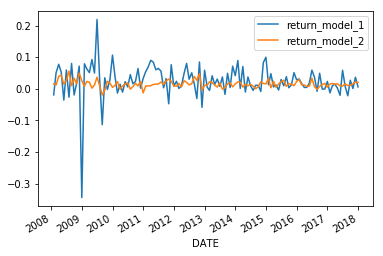

In [128]:
all_test_result.plot()

In [133]:
analysis = all_test_result.describe()
analysis = analysis.drop(["count","min","25%","50%","75%","max"], axis=0)
analysis.loc["annual averge return"] = analysis.loc["mean"] * 12
analysis.loc["annual std"] = analysis.loc["std"] * np.sqrt(12)
analysis.loc["annual Sharp"] = (analysis.loc["mean"]/ analysis.loc["std"]) * np.sqrt(12)
analysis

,return_model_1,return_model_2
mean,0.024857,0.015519
std,0.052401,0.011545
annual averge return,0.298279,0.186233
annual std,0.181522,0.039992
annual Sharp,1.643209,4.656701


it shows that the annual Sharp of our novel method increase for 3 times of the traditional method. And the increased Sharp is mainly from a more stable return